In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
sns.set_context('paper')
pd.set_option('display.max_columns', None)

## Data Preparation and Preprocessing

In [2]:
# import dataframe with both real data and simulation data
with open("../Data/simu1_behav.pkl", 'rb') as inp:
    df = pickle.load(inp)
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350


In [3]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df, category_label_dummies], axis=1) # record the occurrence of every cat label
cl_rolling_sum = category_label_dummies_events.groupby('subject_ID').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df.merge(cl_rolling_sum, on=['subject_ID', 'position'])
df['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], axis = 1) # how many cat within 10 window
df['roll_cat_label_length'] = df['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                labels=['0', '1', '>=2']).astype('str')
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,1
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0


In [4]:
# clean out NA resp
df = df.loc[pd.notna(df.yes)].reset_index(drop=True)
df = df.astype({'yes': 'int32'})
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,1
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197530,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2
197531,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0
197532,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2
197533,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0


In [5]:
# focus on old items
df_old = df.loc[df.lag > 0].reset_index(drop=True)

# add log and log lag bin
df_old['log_lag'] = np.log(df_old['lag'])
df_old['log_lag_bin'] = pd.cut(df_old['log_lag'], np.arange(df_old['log_lag'].max()+1), labels=False, right=False)

# add lag bin
# df_old = df_old.assign(lag_bin = np.ceil(np.log2(df_old['lag'])))
df_old

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,829.330,0,LEMON,18,Uncategorized,1.0,Fruit,21,True,0,NaN,2,151,0,0.0,0,2.890372,2
1,1116.505,0,CROW,15,Birds,8.0,Birds,23,True,1,7.0,7,71,0,0.0,0,2.708050,2
2,827.260,0,CALCULATOR,1,Uncategorized-Singleton,8.0,Electronics,25,True,1,NaN,2,38,0,1.0,1,0.000000,0
3,1204.710,0,BUS,24,Uncategorized,8.0,Vehicles,26,True,1,NaN,2,33,0,0.0,0,3.178054,3
4,1290.270,0,GIRAFFE,29,Uncategorized,8.0,Zoo,34,True,1,NaN,2,115,0,0.0,0,3.367296,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94617,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2,3.610918,3
94618,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0,4.744932,4
94619,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2,3.178054,3
94620,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0,3.713572,3


## Hit Recency with Rolling Category Length Level

In [6]:
df_old.groupby("log_lag_bin").yes.count()

log_lag_bin
0     6752
1    12026
2    21780
3    28862
4    20695
5     4464
6       43
Name: yes, dtype: int64

In [7]:
# df_old.groupby("roll_cat_len_level").yes.count()

In [8]:
# t = df.groupby("lag").yes.count().to_frame(name='count').reset_index()
# t = t.loc[t.lag > 0]
# t

In [9]:
# sns.lineplot(data=t, x='lag',y='count')

#### Origin

In [10]:
# def lag_rollcat(df, resp_col):

#     df_rollcat_laggp = df_old.groupby(['subject_ID','roll_cat_len_level','lag_bin'])[resp_col].mean()
#     df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()
    
# #    df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level, ['0', '>=2'])]
#     df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '1', '>=2'])
    
# #     df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_label_length,[1,2,3,4])]
# #     df_rollcat_laggp = df_rollcat_laggp.loc[df_rollcat_laggp.lag_bin <= 100]
    
#     display(df_rollcat_laggp)

#     g = sns.relplot(x='lag_bin', y='hr', hue='roll_cat_len_level', legend="full", data=df_rollcat_laggp, kind='line')
#     g.set(ylabel='P("Yes" | Old)', xlabel='Lag')
#     g._legend.set_title('Same Category in Past 10 Trials')

In [11]:
# lag_rollcat(df_old,'yes')

#### Log

In [12]:
# df_laggp = df_old.groupby(['lag','roll_cat_len_level']).yes.mean().to_frame(name='hr').reset_index()
# df_laggp.lag = df_laggp.lag.astype('int')
# df_laggp = df_laggp.loc[(df_laggp.lag <= 40) & (df_laggp.lag > 0)]
# df_laggp = df_laggp.loc[np.isin(df_laggp.roll_cat_len_level, ['0', '1'])]
# df_laggp.roll_cat_len_level = df_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '1'])
# display(df_laggp)

In [13]:
# df_0 = df_laggp.loc[df_laggp.roll_cat_len_level == '0']
# df_0 = df_0.hr.rolling(window=3,center=True).mean().to_frame(name='hr_mean')
# df_0

In [14]:
# df_2 = df_laggp.loc[df_laggp.roll_cat_len_level == '1']
# df_2 = df_2.hr.rolling(window=3,center=True).mean().to_frame(name='hr_mean')
# df_2

In [15]:
# df_new = pd.merge(df_laggp, df_0.append(df_2), left_index=True, right_index=True)
# df_new

In [16]:
# sns.pointplot(data=df_new, y='hr_mean', x='lag', hue = 'roll_cat_len_level')
# plt.xlabel('Lag')
# plt.ylabel('P("yes"|old)')
# plt.xticks(rotation=90)
# # plt.savefig('result/behav_hit_recency.jpg')
# plt.show()

In [21]:
def loglag_rollcat(df, resp_col):

    df_rollcat_laggp = df.groupby(['subject_ID','roll_cat_len_level','log_lag_bin'])[resp_col].mean()
    df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()
    df_rollcat_laggp = au.loftus_masson(df_rollcat_laggp, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
    
    df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level,['0','>=2'])]
    df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
    
    df_rollcat_laggp['log_lag_disp'] = np.e**df_rollcat_laggp.log_lag_bin
    
    display(df_rollcat_laggp)
    
    if resp_col == 's_resp':
        ci = None
        linestyle = '-'
    else:
        ci = 95
        linestyle = '--'

    g=sns.lineplot(data=df_rollcat_laggp, y='adj_hr', x='log_lag_disp', hue = 'roll_cat_len_level', ci=ci, linestyle='--', marker = 'o', markersize = 7)
    g.set(ylabel='P("Yes" | Old)', xlabel='Lag')
    
    selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
    plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
    plt.xlim([0,150])
    plt.legend(title = "num of same-cat in prev 8 items")

,subject_ID,roll_cat_len_level,log_lag_bin,hr,M,M_S,adj_hr,log_lag_disp
0,0,0,2,0.965517,0.794033,0.968801,0.790749,7.389056
1,0,0,3,0.973684,0.794033,0.968801,0.798916,20.085537
2,0,0,4,0.866667,0.794033,0.968801,0.691899,54.598150
8,0,>=2,0,1.000000,0.794033,0.968801,0.825232,1.000000
9,0,>=2,1,1.000000,0.794033,0.968801,0.825232,2.718282
...,...,...,...,...,...,...,...,...
5126,656,>=2,1,0.833333,0.794033,0.870568,0.756798,2.718282
5127,656,>=2,2,1.000000,0.794033,0.870568,0.923465,7.389056
5128,656,>=2,3,0.777778,0.794033,0.870568,0.701243,20.085537
5129,656,>=2,4,0.600000,0.794033,0.870568,0.523465,54.598150


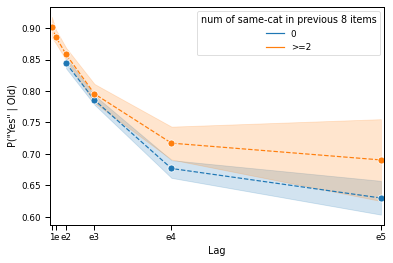

In [22]:
loglag_rollcat(df_old.query('log_lag_bin <= 5'),'yes')
plt.savefig('fig/simu1_David_beh.pdf')